# Network Analysis

Graph of structures burned in the eaton fire with guaranteed connectivity.

In [24]:
import geopandas as gpd
import numpy as np
import networkx as nx
from sklearn.neighbors import BallTree
from tqdm import tqdm
import matplotlib.pyplot as plt

In [32]:
def build_connected_graph_burned_only(gdf, radius=20):
    coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

    # Build BallTree
    tree = BallTree(coords, metric='euclidean')
    neighbors = tree.query_radius(coords, r=radius)

    # Initialize graph
    G = nx.Graph()

    # Add nodes
    for idx in range(len(gdf)):
        G.add_node(idx, burned=gdf.loc[idx, 'burned'])

    # Add edges within 20m (all nodes)
    print("Adding initial edges based on radius...")
    for idx in tqdm(range(len(gdf)), desc="Adding Edges", unit="structure"):
        for nbr in neighbors[idx]:
            if idx != nbr:
                G.add_edge(idx, nbr)

    # Find initial components
    components = list(nx.connected_components(G))
    print(f"Initial number of connected components: {len(components)}")

    # Step 1: Drop components that have no burned structures
    print("Dropping clusters without burned structures...")
    components_to_keep = []
    for comp in components:
        if any(G.nodes[n]['burned'] == 1 for n in comp):
            components_to_keep.append(comp)

    print(f"Components with burned nodes: {len(components_to_keep)}")

    # Build a new graph with only kept components
    G_kept = nx.Graph()
    for comp in components_to_keep:
        G_kept.add_nodes_from((n, G.nodes[n]) for n in comp)
        G_kept.add_edges_from((u, v) for u, v in G.edges(comp))

    G = G_kept  # Replace original G

    # Step 2: Recalculate components
    components = list(nx.connected_components(G))
    print(f"Components after dropping unburned-only clusters: {len(components)}")

    # Step 3: Connect burned nodes across clusters
    pbar = tqdm(desc="Connecting burned clusters", unit="connection", total=len(components) - 1)

    while len(components) > 1:
        # Pick the first component
        comp1 = list(components[0])
        others = [n for comp in components[1:] for n in comp]

        # Burned nodes only
        burned_comp1 = [n for n in comp1 if G.nodes[n]['burned'] == 1]
        burned_others = [n for n in others if G.nodes[n]['burned'] == 1]

        # Sanity check
        if not burned_comp1 or not burned_others:
            raise ValueError("Unexpected empty burned cluster during merge step.")

        # Find closest burned nodes between components
        comp1_coords = coords[burned_comp1]
        others_coords = coords[burned_others]

        tree_other = BallTree(others_coords, metric='euclidean')
        distances, indices = tree_other.query(comp1_coords, k=1)

        min_idx = np.argmin(distances)
        node_from_comp1 = burned_comp1[min_idx]
        node_from_others = burned_others[indices[min_idx][0]]

        # Add an edge between the two burned nodes
        G.add_edge(node_from_comp1, node_from_others)

        # Recalculate components
        components = list(nx.connected_components(G))

        pbar.update(1)

    pbar.close()

    print(f"Number of connected components: {len(components)}. Graph is now fully connected (burned only)!")
    
    return G

In [ ]:
gpkg_file = "data/structures_with_neighbors.gpkg"
layer_name = "structures_with_neighbors"
gdf = gpd.read_file(gpkg_file, layer=layer_name)

# Build graph
G = build_connected_graph_burned_only(gdf, radius=20)

Adding initial edges based on radius...


Adding Edges: 100%|██████████| 18426/18426 [00:00<00:00, 115840.47structure/s]


Initial number of connected components: 9936


Connecting clusters (burned only): 100%|██████████| 9935/9935 [09:29<00:00, 17.44connection/s]

Number of connected components: 1. Graph is now fully connected!


In [27]:
def plot_structure_graph(G, gdf, figsize=(12, 12), node_size=10, xlim=None, ylim=None):
    # Create a position dictionary for NetworkX
    pos = {idx: (gdf.geometry.x[idx], gdf.geometry.y[idx]) for idx in G.nodes()}

    # Node colors: Red for burned (1), Blue for unburned (0)
    node_colors = ['red' if G.nodes[n]['burned'] == 1 else 'blue' for n in G.nodes()]

    plt.figure(figsize=figsize)
    nx.draw(G, pos,
            node_color=node_colors,
            node_size=node_size,
            edge_color='gray',
            width=0.5,
            alpha=0.6,
            with_labels=False)
    
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    plt.title("Structure Connectivity Graph", fontsize=16)
    plt.axis('off')
    plt.show()

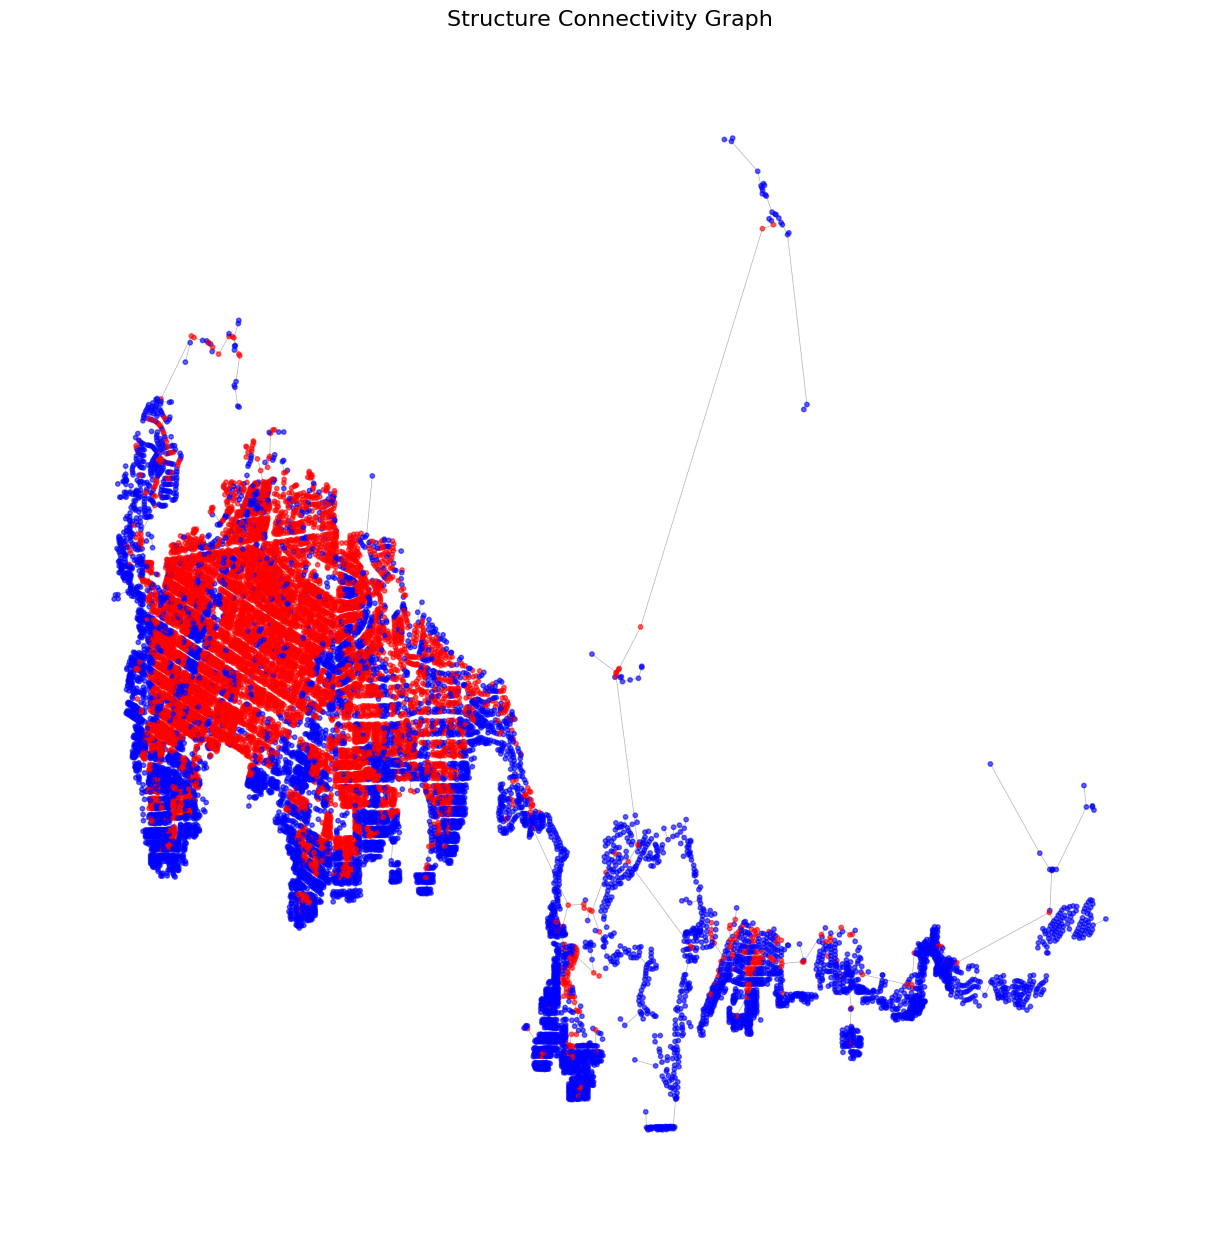

In [28]:
plot_structure_graph(G, gdf)

In [29]:
print(gdf.total_bounds)

[-13153911.2339   4050437.6546 -13137740.9218   4060019.4567]


In [30]:
# Bounds
minx, miny, maxx, maxy = -13153911.2339, 4050437.6546, -13137740.9218, 4060019.4567

# Midpoints
mid_y = (miny + maxy) / 2
quarter_x = minx + 0.25 * (maxx - minx)

# Zoom (6x tighter = 1/6th size window)
half_width = (maxx - minx) / (2 * 6)
half_height = (maxy - miny) / (2 * 6)

# Build zoom window
xlim = (quarter_x - half_width, quarter_x + half_width)
ylim = (mid_y - half_height, mid_y + half_height)

print(f"xlim: {xlim}")
print(f"ylim: {ylim}")

xlim: (-13151216.181883333, -13148521.129866665)
ylim: (4054430.072141667, 4056027.039158333)


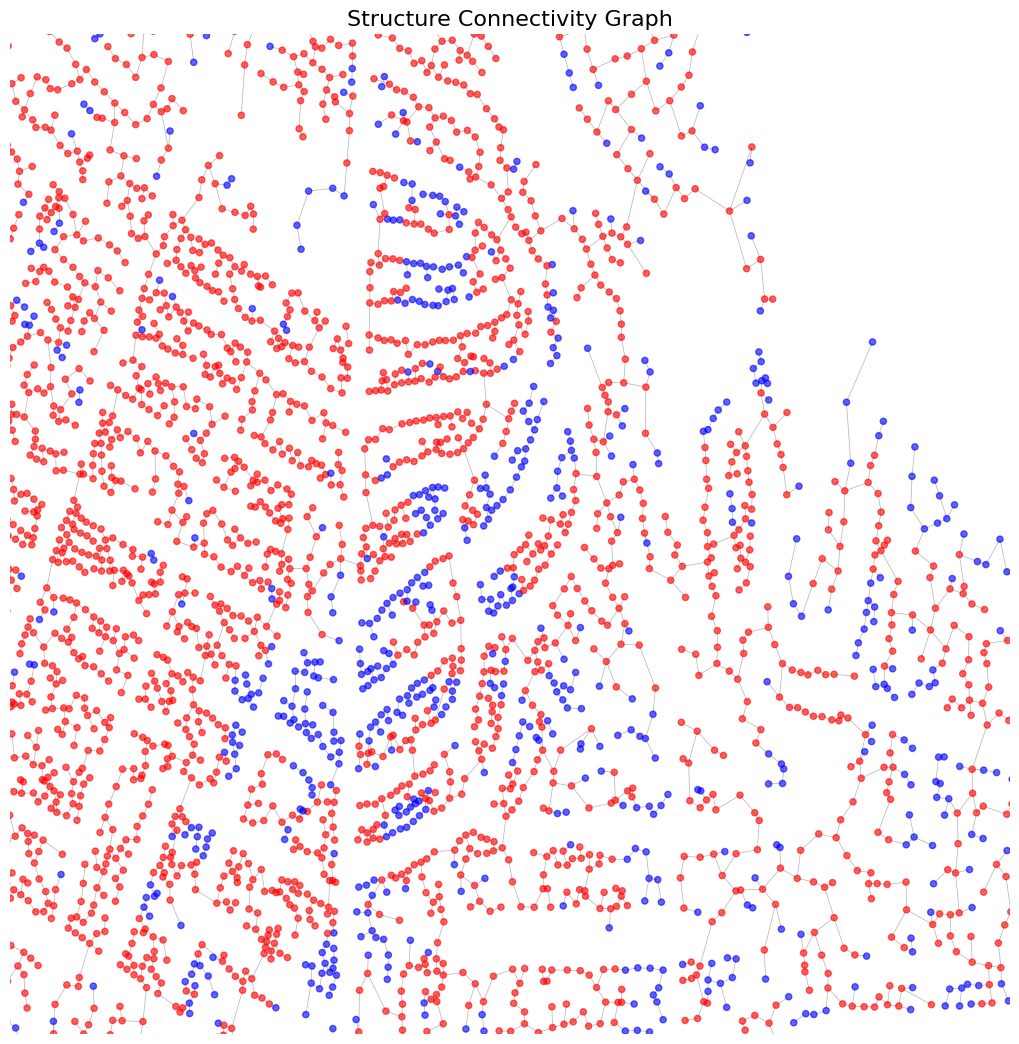

In [31]:
plot_structure_graph(G, gdf,
    xlim=xlim,
    ylim=ylim,
    figsize=(10, 10),
    node_size=20)